## Install Packages

In [1]:
!conda install -y -c conda-forge faiss-gpu
!apt-get -y update
!apt-get -y install libatlas-base-dev

done
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.6.0.*, but conda is ignoring the .* and treating it as 1.6.0
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.9.0.*, but conda is ignoring the .* and treating it as 1.9.0
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - faiss-gpu


The followin

## Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.random_projection import GaussianRandomProjection

from tqdm import tqdm

import faiss

In [3]:
df = pd.read_csv("../story_dataset.csv")
df

,prompt_id,prompt,story,hidden_state_file,len_generated_story,len_new_story
0,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Blaz...,./hidden_states/prompt_1.npz,270,271
1,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Spar...,./hidden_states/prompt_1.npz,349,350
2,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Scor...,./hidden_states/prompt_1.npz,278,278
3,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,117,118
4,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,129,130
...,...,...,...,...,...,...
9995,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,289,290
9996,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,119,119
9997,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,127,128
9998,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,441,441


In [4]:
max_story_len = max(df["len_generated_story"])
max_story_len

522

In [5]:
hidden_states_by_layer = {}
NUM_PROMPTS = 10

for prompt_id in range(1, NUM_PROMPTS + 1):
    with np.load(f'../hidden_states/prompt_{prompt_id}.npz') as loaded_data:
        for i in tqdm(range(1000)):
            curr_hidden_states = loaded_data[f"arr_{i}"][0]
#             print(curr_hidden_states.shape)
            for layer in range(2, 3):
                padded_arr = np.zeros((max_story_len, 512))
                padded_arr_len = len(curr_hidden_states[layer][0])
                
                padded_arr[:padded_arr_len] = curr_hidden_states[layer][0]
                
                padded_arr = padded_arr.flatten().astype('float32') #FAISS expects data in type float32 instead of float64 - saves memory too!
#                 print(padded_arr.shape)
                
                if(f"layer_{layer}" in hidden_states_by_layer):
                    hidden_states_by_layer[f"layer_{layer}"].append(padded_arr)
                else:
                    hidden_states_by_layer[f"layer_{layer}"] = [padded_arr]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:30<00:00, 11.04it/s]


In [6]:
layer_hs_array = np.array(hidden_states_by_layer["layer_2"])
layer_hs_array.shape

(10000, 267264)

## Layer 2 Clustering

In [7]:
# Use original vectors for clustering - uncomment next line and comment out last two lines

# dim_reduced_vecs = layer_hs_array

random_projector = GaussianRandomProjection(random_state = 42)
dim_reduced_vecs = random_projector.fit_transform(layer_hs_array).astype('float32')

In [8]:
dim_reduced_vecs = np.array([v / np.linalg.norm(v) for v in dim_reduced_vecs])
dim_reduced_vecs.shape

(10000, 7894)

In [9]:
prompt_ids = df["prompt_id"]
prompt_ids = prompt_ids.to_numpy()
prompt_ids

array([ 1,  1,  1, ..., 10, 10, 10])

In [10]:
X_train = np.zeros((int(0.8 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_train = np.zeros(int(0.8 * dim_reduced_vecs.shape[0]))

X_test = np.zeros((int(0.2 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_test = np.zeros(int(0.2 * dim_reduced_vecs.shape[0]))

In [11]:
for i in range(10):
    X_train[i * 800 : (i + 1) * 800] = dim_reduced_vecs[i * 1000 : (i * 1000) + 800]
    y_train[i * 800 : (i + 1) * 800] = prompt_ids[i * 1000 : (i * 1000) + 800]
    
    X_test[i * 200 : (i + 1) * 200] = dim_reduced_vecs[(i * 1000) + 800 : (i + 1) * 1000]
    y_test[i * 200 : (i + 1) * 200] = prompt_ids[(i * 1000) + 800 : (i + 1) * 1000]

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 7894)
(8000,)
(2000, 7894)
(2000,)


Sampling a subset of 4000 / 8000 for training
Clustering 4000 points in 7894D to 5 clusters, redo 10 times, 20 iterations
  Preprocessing in 0.11 s
Outer iteration 0 / 10
  Iteration 19 (0.55 s, search 0.29 s): objective=1945.33 imbalance=1.086 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (1.08 s, search 0.57 s): objective=1947.2 imbalance=1.094 nsplit=0        
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (1.61 s, search 0.84 s): objective=1937.55 imbalance=1.062 nsplit=0       
Outer iteration 3 / 10
  Iteration 19 (2.14 s, search 1.11 s): objective=1942.02 imbalance=1.081 nsplit=0       
Outer iteration 4 / 10
  Iteration 19 (2.67 s, search 1.38 s): objective=1939.55 imbalance=1.109 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (3.20 s, search 1.65 s): objective=1939.07 imbalance=1.065 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (3.72 s, search 1.92 s): objective=1934.02 imbalance=1.349 n

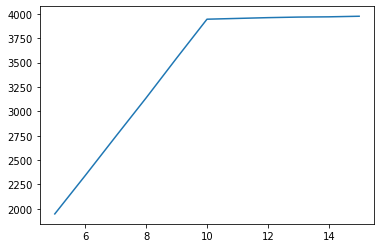

In [13]:
# Elbow Plot
niter = 20
verbose = True
dim = X_train.shape[1]

k_vals = [k for k in range(5, 16)]
wccs = []
for k in k_vals:
    kmeans = faiss.Kmeans(dim, k, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
    kmeans.train(X_train)
    wccs.append(kmeans.obj[-1])

plt.plot(k_vals, wccs)

In [14]:
# K-means Clustering

# ncentroids = NUM_PROMPTS
ncentroids = 10 # Elbow point - based on objective (sum of cosine similarities)
niter = 20
verbose = True
dim = X_train.shape[1]
kmeans = faiss.Kmeans(dim, ncentroids, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
kmeans.train(X_train)


Clustering 8000 points in 7894D to 10 clusters, redo 10 times, 20 iterations
  Preprocessing in 0.04 s
Outer iteration 0 / 10
  Iteration 19 (1.05 s, search 0.54 s): objective=3930.7 imbalance=1.397 nsplit=0        
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (2.11 s, search 1.08 s): objective=3945.03 imbalance=1.126 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (3.18 s, search 1.62 s): objective=3937.62 imbalance=1.232 nsplit=0       
Outer iteration 3 / 10
  Iteration 19 (4.29 s, search 2.18 s): objective=3940.69 imbalance=1.076 nsplit=0       
Outer iteration 4 / 10
  Iteration 19 (5.34 s, search 2.72 s): objective=3910.49 imbalance=2.139 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (6.40 s, search 3.26 s): objective=3940.53 imbalance=1.123 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (7.51 s, search 3.82 s): objective=3934.35 imbalance=1.238 nsplit=0       
Outer iteration 7 / 10
  Iter

3945.030029296875

In [15]:
kmeans.centroids #cluster centers

array([[ 0.01464519, -0.00500439,  0.0128459 , ...,  0.00271273,
         0.00783452,  0.01466251],
       [ 0.0137897 , -0.00525204,  0.01200565, ...,  0.00086048,
         0.01674183,  0.01908222],
       [ 0.01390902, -0.01164836,  0.00910922, ...,  0.00025399,
         0.00583742,  0.01501025],
       ...,
       [ 0.01538714, -0.00596671,  0.01069167, ...,  0.00279974,
         0.00719184,  0.01611486],
       [ 0.02141245, -0.00144417,  0.01189291, ...,  0.00110883,
         0.00919046,  0.01356508],
       [ 0.01705309, -0.00494285,  0.01493528, ...,  0.00070973,
         0.01198907,  0.01388743]], dtype=float32)

In [16]:
for centroid in kmeans.centroids:
    print(np.linalg.norm(centroid))

1.0000004
0.9999999
1.0000001
1.0
0.9999999
1.0000001
1.0000004
0.9999998
1.0000001
0.9999998


In [17]:
kmeans.obj #inertia at each iteration

array([2552.8425293 , 3794.54516602, 3865.08105469, 3893.27807617,
       3905.28393555, 3912.73510742, 3918.56445312, 3922.12548828,
       3925.03466797, 3927.36914062, 3928.98925781, 3929.8112793 ,
       3930.31567383, 3930.53149414, 3930.61914062, 3930.67114258,
       3930.68896484, 3930.69042969, 3930.69018555, 3930.69555664,
       2626.09985352, 3800.81103516, 3833.27563477, 3866.17236328,
       3896.05834961, 3914.74414062, 3924.86572266, 3931.75390625,
       3936.69042969, 3939.82495117, 3941.47875977, 3942.42822266,
       3943.07397461, 3943.53759766, 3943.80932617, 3944.11108398,
       3944.43505859, 3944.71801758, 3944.91381836, 3945.0300293 ])

In [18]:
cos_similarities = X_train @ kmeans.centroids.T
classifications_train = np.argmax(cos_similarities, axis=1)

In [19]:
pd.Series(classifications_train).value_counts()

5    1212
4    1188
0    1071
1     955
6     786
3     715
2     649
7     613
8     459
9     352
dtype: int64

In [20]:
# Get most common label for each point classified to a centroid (same centroid)
centroid_labels = [np.where(classifications_train == i)[0] for i in range(ncentroids)]
max_label_per_centroid = [int(pd.Series(y_train[centroid_labels[i]]).value_counts().idxmax()) for i in range(ncentroids)]
max_label_per_centroid

[2, 6, 3, 4, 5, 1, 5, 9, 10, 10]

In [21]:
centroid_to_label = {idx : max_label_per_centroid[idx] for idx in range(len(max_label_per_centroid))}

In [22]:
centroid_to_label

{0: 2, 1: 6, 2: 3, 3: 4, 4: 5, 5: 1, 6: 5, 7: 9, 8: 10, 9: 10}

In [23]:
vectorized_map = np.vectorize(centroid_to_label.get)
classifications_to_label = vectorized_map(classifications_train)

classifications_to_label

array([ 4,  9,  9, ..., 10, 10, 10])

In [24]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label[i * 800:(i + 1) * 800] == (i + 1)))

Prompt 1 Accuracy:  0.29
Prompt 2 Accuracy:  0.27
Prompt 3 Accuracy:  0.16125
Prompt 4 Accuracy:  0.18625
Prompt 5 Accuracy:  0.75375
Prompt 6 Accuracy:  0.28125
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.24375
Prompt 10 Accuracy:  0.98


In [25]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label == y_train))

Overall Accuracy:  0.316625


## Perform Inference on Test Set & Collect Test Accuracy

In [26]:
cos_similarities = X_test @ kmeans.centroids.T
classifications_test = np.argmax(cos_similarities, axis=1)

In [27]:
pd.Series(classifications_test).value_counts()

5    318
4    296
0    245
1    225
6    203
3    177
2    169
7    164
8    119
9     84
dtype: int64

In [28]:
classifications_to_label_test = vectorized_map(classifications_test)

classifications_to_label_test

array([ 1,  9,  5, ..., 10, 10, 10])

In [29]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label_test[i * 200:(i + 1) * 200] == (i + 1)))

Prompt 1 Accuracy:  0.31
Prompt 2 Accuracy:  0.215
Prompt 3 Accuracy:  0.225
Prompt 4 Accuracy:  0.185
Prompt 5 Accuracy:  0.81
Prompt 6 Accuracy:  0.25
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.3
Prompt 10 Accuracy:  0.985


In [30]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label_test == y_test))

Overall Accuracy:  0.328


## Confusion Matrix of Results

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

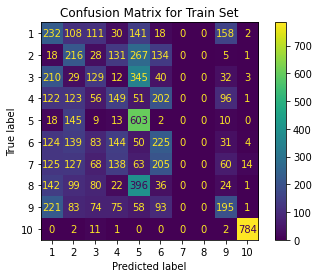

In [32]:
cm = confusion_matrix(y_train, classifications_to_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Train Set')
plt.show()

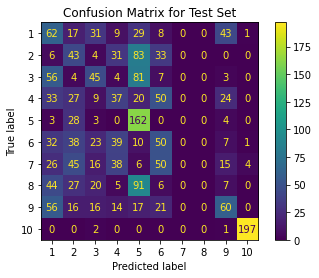

In [33]:
cm = confusion_matrix(y_test, classifications_to_label_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()